In [1]:
#!/usr/bin/env python3
# _*_ coding: utf-8 _*_

import sys

sys.path.append("../..")

In [2]:
from d2l import d2l_cn as d2l

LSTM 中引入了3个门，即输入门（input gate）、遗忘门（forget gate）和输出门（output gate），以及与隐藏状态形状相同的记忆细胞（某些文献把记忆细胞当成一种特殊的隐藏状态），从而记录额外的信息。

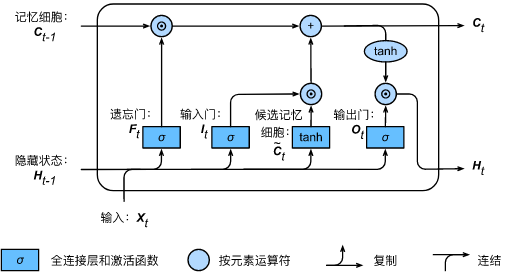

In [3]:
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
(corpus_indices, char_to_idx, idx_to_char, vocab_size) = d2l.load_data_jay_lyrics()

In [4]:
num_inputs, num_hiddens, num_outputs = vocab_size, 256, vocab_size

In [15]:
def get_params():
    def _one(shape):
        ts = torch.tensor(np.random.normal(0,0.01,size=shape),device = device, dtype=torch.float32)
        return torch.nn.Parameter(ts,requires_grad = True)
    
    def _three():
        return (_one((num_inputs,num_hiddens)), 
               _one((num_hiddens,num_hiddens)), 
                torch.nn.Parameter(torch.zeros(num_hiddens, device = device, dtype=torch.float32),requires_grad=True)
               )
    
    W_xi, W_hi, b_i = _three() #输入门
    W_xf, W_hf, b_f = _three() #遗忘门
    W_xo, W_ho, b_o = _three() #输出门
    W_xc, W_hc, b_c = _three() #候选记忆细胞
    
    W_hq = _one((num_hiddens,num_outputs))
    b_q = torch.nn.Parameter(torch.zeros(num_outputs, device = device, dtype = torch.float32), requires_grad = True)
    
    return nn.ParameterList([W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c, W_hq, b_q])

In [16]:
def init_lstm_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device = device),
           torch.zeros((batch_size, num_hiddens), device = device)) # 隐藏状态和cell状态

In [20]:
def lstm(inputs, state, params):
    [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c, W_hq, b_q] = params
    (H, C) = state
    outputs = []
    for X in inputs:
        I = torch.sigmoid(torch.matmul(X,W_xi) + torch.matmul(H, W_hi) + b_i)#输入门
        F = torch.sigmoid(torch.matmul(X,W_xf) + torch.matmul(H,W_hf) + b_f)#遗忘门
        O = torch.sigmoid(torch.matmul(X, W_xo) + torch.matmul(H, W_ho) + b_o) # 输出门
        C_tilde = torch.tanh(torch.matmul(X,W_xc) + torch.matmul(H, W_hc) + b_c) #候选记忆细胞参数
        C = F * C + I * C_tilde #element wise
        H = O * C.tanh()
        Y = torch.matmul(H,W_hq) + b_q
        
        outputs.append(Y)
        
    return outputs, (H,C)

In [21]:
num_epochs, num_steps, batch_size, lr, clipping_theta = 160, 35, 32, 1e2, 1e-2
pred_period, pred_len, prefixes = 40, 50, ['分开', '不分开']

In [22]:
d2l.train_and_predict_rnn(lstm, get_params, init_lstm_state, num_hiddens,
                          vocab_size, device, corpus_indices, idx_to_char,
                          char_to_idx, False, num_epochs, num_steps, lr,
                          clipping_theta, batch_size, pred_period, pred_len,
                          prefixes)

KeyboardInterrupt: 

### 直接使用lstm

In [23]:
lr = 1e-2
lstm_layer = nn.LSTM(input_size = vocab_size, hidden_size = num_hiddens)
model = d2l.RNNModel(lstm_layer, vocab_size)

AttributeError: module 'd2l.d2l_cn' has no attribute 'RNNModel'